# **Fine Tuning**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import random
import shutil
import zipfile
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.utils import resample

# Plot immagini
import seaborn as sns
from skimage import io
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

# Deep learning
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import image_dataset_from_directory
from tensorflow.keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
# Architecture
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B0
from tensorflow.keras.applications.vgg16 import VGG16
# Recall
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from tensorflow.keras.metrics import Recall

In [3]:
DATA_PATH = '/content/drive/MyDrive/Progetto Data Lab/Dati/'
#train_path = DATA_PATH + 'dataset/train'
#test_path = DATA_PATH + 'dataset/test'
MODEL_PATH = '/content/drive/MyDrive/Progetto Data Lab/Model/'

## Resize Dataset (**non eseguire**)

In [ ]:
def load_zip(path, filename, dest):
  """
  Funzione per copiare ed estrarre in locale i file .zip. Il file originale, se
  richiesto, viene eliminato.
  
  :param str path: Percorso per lo zip
  :param str filename: Nome dello zip
  :param str dest: nome della cartella destinazione dei file
  """
  # Estrazione dello zip
  with zipfile.ZipFile(path + filename, 'r') as z:
    z.extractall('./' + dest,)

In [ ]:
# Download zip dei dati
load_zip(DATA_PATH, 'dataset/train.zip', 'train')

In [ ]:
label = pd.read_csv(DATA_PATH + 'Labels/train_labels.csv')
label.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [ ]:
# Suddivisione nelle classi
print(label['label'].value_counts())

0    130908
1     89117
Name: label, dtype: int64


In [ ]:
# Bilanciamento del dataset
neg_class = label[label['label'] == 0] # no tumore
pos_class = label[label['label'] == 1]

# Estrazione 14500 istanze per classe (12000 per il training e 2500 per il test)
seed = 42
df_neg = resample(neg_class, replace = False, n_samples = 6000,
                  random_state = seed)
df_pos = resample(pos_class, replace = False, n_samples = 6000,
                  random_state = seed)

df_neg_train = df_neg[0:5000]
df_neg_test = df_neg[5000:]

df_pos_train = df_pos[0:5000]
df_pos_test = df_pos[5000:]

# Concatenazione df e salvataggio
label_reduced_train = pd.concat([df_pos_train, df_neg_train])
label_reduced_train.to_csv(DATA_PATH + 'train_reduced_label.csv', index = False, 
                      header = True)

label_reduced_test = pd.concat([df_pos_test, df_neg_test])
label_reduced_test.to_csv(DATA_PATH + 'test_reduced_label.csv', index = False, 
                      header = True)

In [ ]:
def generate_reduced_dataset(data_set, label, df_label_small):
  """
  :param str data_set: 'test' o 'train'
  :param int label: le due possibili classi, 0 o 1
  :param df df_label_small: dataset ridimensionato con le label
  """
  train_dir = DATA_PATH + data_set
  sub_fold = train_dir + '/' + str(label)
  if not os.path.exists(train_dir):
    os.makedirs(train_dir)
   # Sub-folder con la classi
  if not os.path.exists(sub_fold):
    os.makedirs(sub_fold) 

  # Spostamento immagini nella sub-folder
  for _, row in df_label_small.iterrows():
    filename = row['id'] + '.tif'

    shutil.copy2('/content/train/' + filename, sub_fold + '/' + filename)

In [ ]:
# Generazione train small
generate_reduced_dataset('train', 0, df_neg_train)
generate_reduced_dataset('train',1, df_pos_train)

In [ ]:
# Generazione test small
generate_reduced_dataset('test', 0, df_neg_test)
generate_reduced_dataset('test',1, df_pos_test)

## Import images

In [4]:
train_path = DATA_PATH + 'train'
test_path = DATA_PATH + 'test'
def import_data(img_size = (96,96), val_split = 0.1, batch_size = 64,
                train_path = train_path, test_path = test_path):
  """
  Funzione per l'importazione delle immagini di training e di validation
  """
  image_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1./255, 
                                                                 validation_split = val_split
                                                                 )
  # Training set
  train_set = image_generator.flow_from_directory(
      train_path, 
      class_mode = 'categorical', 
      classes = ['0', '1'], 
      color_mode = 'rgb',
      shuffle = True,
      target_size = img_size, 
      batch_size = batch_size, 
      subset = 'training', # carica un subset di training (90%)
      seed = 1
  )

  val_set = image_generator.flow_from_directory(
      train_path,
      classes = ['0', '1'],
      class_mode='categorical',
      color_mode = 'rgb',
      shuffle = False, 
      target_size = img_size,
      batch_size = batch_size,
      subset = 'validation', 
      seed = 1
  )

  # carico il test set
  test_set = image_generator.flow_from_directory(
      test_path,
      classes = ['0','1'], # è stata creata una classe fittizia per poter utilizzare flow_from_directory
      class_mode='categorical',
      color_mode = 'rgb',
      shuffle = False, 
      target_size = img_size,
      batch_size = batch_size
  )

  return train_set, val_set, test_set

In [ ]:
len(os.listdir(test_path + '/0'))

In [5]:
train_set, val_set, test_set = import_data()

Found 9000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


### Contenuto del dataset

In [ ]:
img, _,_ = import_data(img_size = (96,96))

Found 9000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


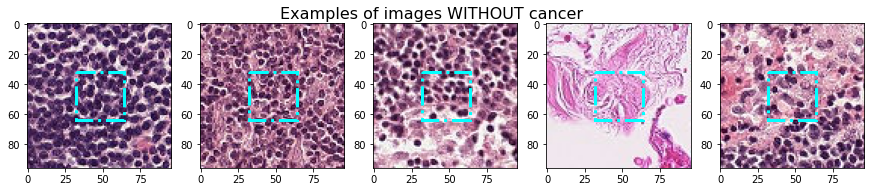

In [ ]:
# NO TUMORE
fig, ax = plt.subplots(1,5, figsize=(15,5))

plotted_img = 0
lst_plotted_img = []

while plotted_img < 5:
  idx = random.randint(0, 63)

  # se la label dell'immagine è = 0 e non l'avevo ancora estratta la visualizzo
  if (idx not in lst_plotted_img) and (np.argmax(img[0][1][idx]) == 0):
    ax[plotted_img].imshow(img[0][0][idx])

    # Quadrato che evidenzia la regione centrale
    p = Polygon(((32, 32), (64, 32), (64, 64), (32, 64)), # posizione
                ec = 'aqua', #colore bordo
                fc = (0, 0, 0, 0), #colore interno
                lw = 3, # spessore
                linestyle='-.')
    ax[plotted_img].add_patch(p)

    plotted_img = plotted_img + 1
    lst_plotted_img.append(idx)


fig.suptitle('Examples of images WITHOUT cancer', y=0.75, fontsize=16)
plt.show()

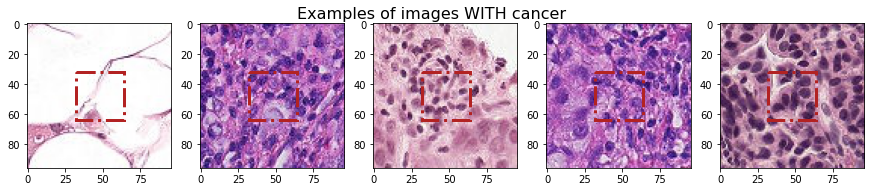

In [ ]:
# TUMORE
fig, ax = plt.subplots(1,5, figsize=(15,5))

plotted_img = 0
lst_plotted_img = []

while plotted_img < 5:
  idx = random.randint(0, 63)

  if (idx not in lst_plotted_img) and (np.argmax(img[0][1][idx]) == 1):
    ax[plotted_img].imshow(img[0][0][idx])

    # Quadrato che evidenzia la regione centrale
    p = Polygon(((32, 32), (64, 32), (64, 64), (32, 64)), # posizione
                ec = 'firebrick', #colore bordo
                fc = (0, 0, 0, 0), #colore interno
                lw = 3, # spessore
                linestyle='-.')
    ax[plotted_img].add_patch(p)

    plotted_img = plotted_img + 1
    lst_plotted_img.append(idx)


fig.suptitle('Examples of images WITH cancer', y=0.75, fontsize=16)
plt.show()

## **Fine Tuning**

In [6]:
INPUT_SHAPE = (224,224,3)
NUM_CLASSES = 2

### Funzioni ausiliarie
In questa sezione sono raccolte una serie di funzioni che ci saranno utili in fase di addestramento e valutazione dei modelli. In particolare svolgono i seguenti compiti:
- addestramento del modello con la possibilità di scegliere se usare l'Early Stopping;
- calcolo della predizione;
- plot delle curve di loss e accuracy per il training e il validation set;
- visualizzazione dei risultati attraverso una serie di metriche e il plot della matrice di confusione.

In [10]:
def train_model(model, bs = 128, eps = 50, early_stopping = True, pat = 3,
                min_d = 0.001):
  """
  Viene eseguito il fit del modello su un numero di epoche fissato.
  :param keras.engine.functional.Functional model: modello da addestrare
  :param int bs: batch size
  :param int eps: numero di epoche desiderato
  :param bool early_stopping: parametro booleano che specifica se utilizzare o
  meno l'Early Stopping
  :param int pat: numero di epoche da eseguire se non si verificano miglioramenti
  :param float min_d: variazione minima richiesta
  """
  early_stop = None
  if early_stopping == True:
    early_stop = EarlyStopping(monitor = 'val_loss', patience = pat,
                               min_delta = min_d, restore_best_weights = True,
                               verbose = 1) 

    history = model.fit(train_set, epochs = eps, validation_data = val_set,
                        batch_size = bs, callbacks = [early_stop], verbose = 1,
                        shuffle = True)
    
  else:
    history = model.fit(train_set, epochs = eps, validation_data = val_set,
                        batch_size = bs, verbose = 1)
  return history, early_stop

In [11]:
def plot_history(history, early_stop = None, plot_size = (15,5)):
  """
  Visualizza a video alcune informazioni testuali di base sul training del
  modello e due grafici per analizzare l'andamento della loss e dell'accuracy
  durante il training
  
  :param keras.callbacks.History history: history del modello contenente i valori 
  di loss e accuracy per training e validation set
  :param keras.callbacks.EarlyStopping early_stop: early stopping utilizzato in
  fase di addestramento
  :param tuple plot_size: dimensione del plot
  """

  if early_stop is not None:
    if early_stop.stopped_epoch != 0:
      epochs = early_stop.stopped_epoch + 1
    else:
      early_stop.best_epoch + 1
    best_epoch = early_stop.best_epoch + 1
  else:
    epochs = len(history.epoch)
    best_epoch = epochs

  fig = plt.figure(figsize = plot_size)

  plt.subplot(1, 2, 1)
  plt.xlabel('Epochs'); plt.ylabel('Loss');  plt.title('Model loss')
  plt.xticks(np.arange(len(history.epoch)), np.arange(1, len(history.epoch)+1))
  plt.plot(range(0,best_epoch,1), 
           history.history['loss'][:best_epoch], '.-', color="C0") 
  plt.plot(range(0,best_epoch,1), 
           history.history['val_loss'][:best_epoch], '.-', color="C1")
  plt.plot(range(best_epoch-1, len(history.epoch),1), 
           history.history['loss'][best_epoch-1:], '.--', color="C0") 
  plt.plot(range(best_epoch-1, len(history.epoch),1), 
           history.history['val_loss'][best_epoch-1:], '.--', color="C1")
  plt.legend(['Training', 'Validation'])

  plt.subplot(1, 2, 2)
  plt.xlabel('Epochs'); plt.ylabel('Accuracy');  plt.title('Model accuracy')
  plt.xticks(np.arange(len(history.epoch)), np.arange(1, len(history.epoch)+1))
  plt.plot(range(0,best_epoch,1), 
           history.history['accuracy'][:best_epoch], '.-', color="C0") 
  plt.plot(range(0,best_epoch,1), 
           history.history['val_accuracy'][:best_epoch], '.-', color="C1")
  plt.plot(range(best_epoch-1, len(history.epoch),1), 
           history.history['accuracy'][best_epoch-1:], '.--', color="C0") 
  plt.plot(range(best_epoch-1, len(history.epoch),1), 
           history.history['val_accuracy'][best_epoch-1:], '.--', color="C1") 
  plt.legend(['Training', 'Validation'], loc='lower right')

  print('Informazioni utili: \n')
  print('Numero di epoche totali:', epochs)
  print('Epoca migliore (weights restored):', best_epoch)
  print('Accuracy training set all\'epoca ' + str(best_epoch) + ': ' 
        + str(history.history['accuracy'][best_epoch -1]))
  print('Accuracy validation set all\'epoca ' + str(best_epoch) + ': '
        + str(history.history['val_accuracy'][best_epoch -1]))
  print('Loss training set all\'epoca ' + str(best_epoch) + ': '
        + str(history.history['loss'][best_epoch -1]))
  index = history.history['val_loss'].index(early_stop.best)
  print('Loss validation set all\'epoca ' + str(best_epoch) + ': ' 
        + str(history.history['val_loss'][index]))
  print('\n\n')

In [12]:
def make_prediction(model, test_set):
  """
  Determina la classificazione per il test set dato un modello
  :param keras.engine.functional.Functional model: modello usato per la
  classificazione
  :param BatchDataset: testing set
  """
  y_prediction = model.predict(test_set)
  y_pred = []
  for i in range(len(y_prediction)):
    y_pred.append(np.argmax(y_prediction[i]))
  y_pred = np.array(y_pred)

  return y_pred

In [13]:
def evaluate_prediction(model, y_test, y_pred, labels, plot_size = (15,15),
                        dpi = 100, color = "PuRd"): 
  """
  Calcola e visualizza graficamente alcune metriche sulle predizioni
  
  :param keras.engine.functional.Functional model: modello keras trainato con
  cui effettuare le predizioni
  :param string y_test: lista contenente le label del test set
  :param string y_pred: lista contenente le label della classificazione
  :param string labels: lista contenente i nomi dei pittori
  """
  # Classification report
  cl = classification_report(y_test, y_pred, target_names = labels)
  print('\nClassification Report\n', cl)

  # Confusion matrix
  cm = confusion_matrix(y_test, y_pred)

  fig, ax = plt.subplots(figsize=plot_size, dpi=dpi)
  sns.heatmap(cm, annot=True, fmt='g', cmap=color) 
  ax.set_title('Confusion Matrix');
  ax.set_xlabel('Predicted labels'); ax.set_ylabel('Actual labels');
  ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
  plt.xticks(rotation='vertical'); plt.yticks(rotation='horizontal')

In [14]:
def plot_roc(y_test, y_hat):
  fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_hat)
  auc_keras = auc(fpr_keras, tpr_keras)

  plt.figure()
  plt.plot(fpr_keras,tpr_keras)

  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.text(x=0.4, y=0.4 , s = f'AUC: {round(auc_keras,3)}', bbox = dict(boxstyle= 'square', color = 'lightblue'), fontsize = 16)
  plt.show()

### MobileNetV2

In [ ]:
# Import MobileNetV2
base_model_mn = MobileNetV2(weights = 'imagenet')

# Esclusione dell'ultimo layer denso
base_model_mn = Model(inputs = base_model_mn.input, 
                      outputs = base_model_mn.get_layer('global_average_pooling2d').output)

14548992/14536120 [==============================] - 0s 0us/step


In [ ]:
base_model_mn.summary()

In [ ]:
def mobilenet_tuning(base_model, lr, augmentation = True): 
  """
  Funzione per il fine-tuning e la specificazione della rete MobileNetV2
  :param base_mode: modello base pre-addestrato
  :param float lr: valore del learning rate dell'ottimizzatore
  :param bool augmentation: True se si vuole effettuare Data Augmentation
  """
  # Reset sezione
  keras.backend.clear_session()
  keras.backend.reset_uids()
  
  # Freezing dei layer di MobileNetV2
  for layer in base_model.layers:
    layer.trainable = False
  
  # Input layer
  inputs = keras.Input(shape=INPUT_SHAPE)
  x = inputs

  # Data Augmentation
  if augmentation == True:
    x = keras.layers.RandomContrast(0.2)(x)

  # Preprocessing dei dati
  x = keras.applications.mobilenet_v2.preprocess_input(x)
  x = base_model(x)

  # Specificazione del modello
  x = keras.layers.Dense(128, activation = 'relu')(x) 
  x = keras.layers.Dropout(0.2)(x)
  x = keras.layers.Dense(32, activation = 'relu')(x) 
  x = keras.layers.Dropout(0.5)(x)
  x = keras.layers.Dense(8, activation = 'relu')(x) 
  #x = keras.layers.Dropout(0.4)(x)
  x = keras.layers.Dense(NUM_CLASSES, activation = 'sigmoid')(x)

  # Modello finale
  outputs = x
  model = keras.Model(inputs=inputs, outputs=outputs)

  # Compilazione modello
  model.compile(optimizer = Adam(lr),
                  loss = 'binary_crossentropy',
                  metrics = ['accuracy', Recall(name = 'recall')])
  return model

In [ ]:
model_mn = mobilenet_tuning(base_model_mn, lr = 0.0001) 

In [ ]:
model_mn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 random_contrast (RandomCont  (None, 224, 224, 3)      0         
 rast)                                                           
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 model (Functional)          (None, 1280)              2257984   
                                                             

In [ ]:
# Training
history_mn, early_stopping = train_model(model_mn, bs = 64, eps = 25, early_stopping = True, pat = 3)

Epoch 1/25
141/141 [==============================] - 1338s 9s/step - loss: 0.7027 - accuracy: 0.5021 - recall: 0.6364 - val_loss: 0.6920 - val_accuracy: 0.5000 - val_recall: 0.5020
Epoch 2/25
141/141 [==============================] - 68s 483ms/step - loss: 0.6946 - accuracy: 0.5069 - recall: 0.5557 - val_loss: 0.6900 - val_accuracy: 0.6080 - val_recall: 0.5060
Epoch 3/25
141/141 [==============================] - 68s 482ms/step - loss: 0.6931 - accuracy: 0.5149 - recall: 0.5269 - val_loss: 0.6896 - val_accuracy: 0.5720 - val_recall: 0.4800
Epoch 4/25
141/141 [==============================] - 68s 480ms/step - loss: 0.6902 - accuracy: 0.5326 - recall: 0.5429 - val_loss: 0.6860 - val_accuracy: 0.6170 - val_recall: 0.4670
Epoch 5/25
141/141 [==============================] - 68s 481ms/step - loss: 0.6901 - accuracy: 0.5302 - recall: 0.5148 - val_loss: 0.6838 - val_accuracy: 0.5950 - val_recall: 0.5570
Epoch 6/25
141/141 [==============================] - 68s 484ms/step - loss: 0.6855 - 

In [ ]:
model_mn.save('/content/drive/MyDrive/BioLab/MobileNet_tuning.h5')

Informazioni utili: 

Numero di epoche totali: 8
Epoca migliore (weights restored): 5
Accuracy training set all'epoca 5: 0.699954092502594
Accuracy validation set all'epoca 5: 0.6887052059173584
Loss training set all'epoca 5: 0.5632517337799072
Loss validation set all'epoca 5: 0.5358368754386902





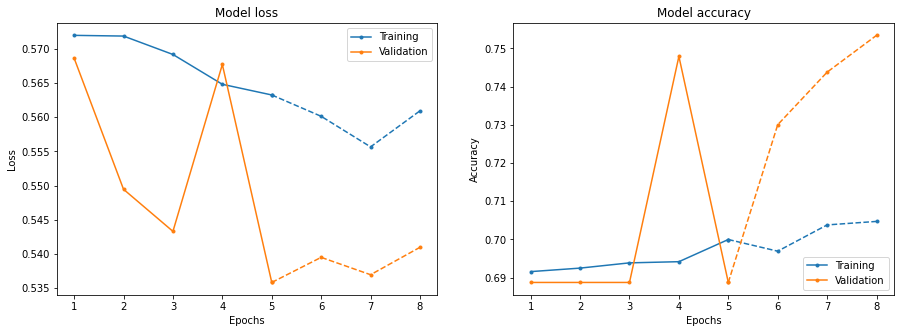

In [ ]:
plot_history(history_mn, early_stop = early_stopping)

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/BioLab/MobileNet_tuning.h5')

In [ ]:
pred = make_prediction(model_mn, test_set)


Classification Report
               precision    recall  f1-score   support

          No       0.67      0.83      0.74      1000
          Sì       0.78      0.58      0.66      1000

    accuracy                           0.71      2000
   macro avg       0.72      0.71      0.70      2000
weighted avg       0.72      0.71      0.70      2000



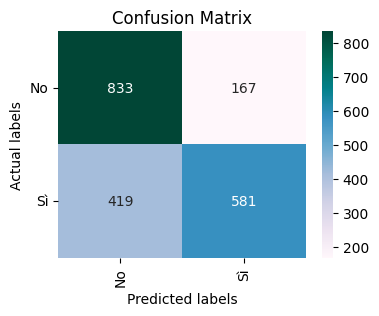

In [ ]:
evaluate_prediction(model_mn, test_set.labels, pred, ['No','Sì'],
                    plot_size = (4,3), dpi = 100, color = 'PuBuGn')

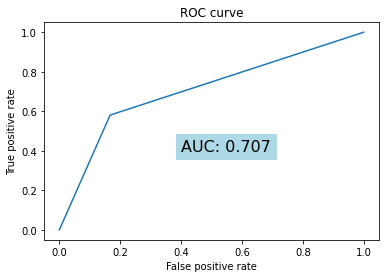

In [ ]:
plot_roc(test_set.labels, pred)

## EfficientNetV2B0

In [20]:
# Import MobileNetV2
base_model_en = EfficientNetV2B0(weights = 'imagenet')

# Esclusione dell'ultimo layer denso
base_model_en = Model(inputs = base_model_en.input, 
                      outputs = base_model_en.get_layer('top_dropout').output)

29417472/29403144 [==============================] - 0s 0us/step


In [ ]:
base_model_en.summary()

In [21]:
def effNet_tuning(base_model, lr, augmentation = True): 
  """
  Funzione per il fine-tuning e la specificazione della rete MobileNetV2
  :param base_mode: modello base pre-addestrato
  :param float lr: valore del learning rate dell'ottimizzatore
  :param bool augmentation: True se si vuole effettuare Data Augmentation
  """
  # Reset sezione
  keras.backend.clear_session()
  keras.backend.reset_uids()
  
  # Freezing dei layer di MobileNetV2
  for layer in base_model.layers:
    layer.trainable = False
  
  # Input layer
  inputs = keras.Input(shape=INPUT_SHAPE)
  x = inputs

  # Data Augmentation
  if augmentation == True:
    x = keras.layers.RandomContrast(0.2)(x)

  # Preprocessing dei dati
  x = keras.applications.efficientnet_v2.preprocess_input(x)
  x = base_model(x)

  # Specificazione del modello
  x = keras.layers.Dense(128, activation = 'relu')(x) 
  x = keras.layers.Dropout(0.2)(x)
  x = keras.layers.Dense(32, activation = 'relu')(x) 
  x = keras.layers.Dropout(0.5)(x)
  x = keras.layers.Dense(8, activation = 'relu')(x) 
  #x = keras.layers.Dropout(0.4)(x)
  x = keras.layers.Dense(NUM_CLASSES, activation = 'sigmoid')(x)

  # Modello finale
  outputs = x
  model = keras.Model(inputs=inputs, outputs=outputs)

  # Compilazione modello
  model.compile(optimizer = Adam(lr),
                  loss = 'binary_crossentropy',
                  metrics = ['accuracy', Recall(name = 'recall')])
  return model

In [22]:
model_en = effNet_tuning(base_model_en, lr = 0.0001) 

In [ ]:
model_mn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 random_contrast (RandomCont  (None, 224, 224, 3)      0         
 rast)                                                           
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 model (Functional)          (None, 1280)              2257984   
                                                             

In [24]:
# Training
history_en, early_stopping = train_model(model_en, bs = 64, eps = 25,
                                         early_stopping = True, pat = 5, min_d = 0.0005)

Epoch 1/25
141/141 [==============================] - 3622s 26s/step - loss: 0.6950 - accuracy: 0.4904 - recall: 0.3924 - val_loss: 0.6931 - val_accuracy: 0.5000 - val_recall: 0.0000e+00
Epoch 2/25
141/141 [==============================] - 87s 614ms/step - loss: 0.6937 - accuracy: 0.5026 - recall: 0.3586 - val_loss: 0.6931 - val_accuracy: 0.5000 - val_recall: 0.0000e+00
Epoch 3/25
141/141 [==============================] - 85s 602ms/step - loss: 0.6937 - accuracy: 0.5010 - recall: 0.2694 - val_loss: 0.6931 - val_accuracy: 0.5000 - val_recall: 0.0000e+00
Epoch 4/25
141/141 [==============================] - 85s 605ms/step - loss: 0.6934 - accuracy: 0.5009 - recall: 0.2401 - val_loss: 0.6931 - val_accuracy: 0.5000 - val_recall: 0.0000e+00
Epoch 5/25
141/141 [==============================] - 87s 613ms/step - loss: 0.6934 - accuracy: 0.4920 - recall: 0.2013 - val_loss: 0.6931 - val_accuracy: 0.5000 - val_recall: 0.0000e+00
Epoch 6/25
141/141 [==============================] - 85s 602ms/s

In [ ]:
model_mn.save('/content/drive/MyDrive/BioLab/EfNet_tuning.h5')

In [ ]:
plot_history(history_mn, early_stop = early_stopping)

In [8]:
# Load model
model_en = keras.models.load_model(MODEL_PATH +'EfNet_tuning.h5')

In [25]:
pred = make_prediction(model_en, test_set)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classification Report
               precision    recall  f1-score   support

          No       0.50      1.00      0.67      1000
          Sì       0.00      0.00      0.00      1000

    accuracy                           0.50      2000
   macro avg       0.25      0.50      0.33      2000
weighted avg       0.25      0.50      0.33      2000



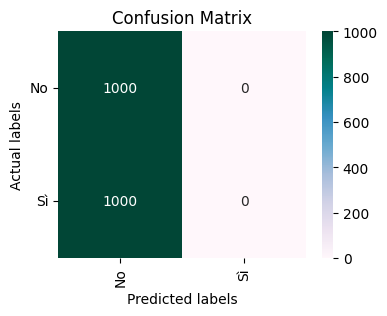

In [26]:
evaluate_prediction(model_en, test_set.labels, pred, ['No','Sì'],
                    plot_size = (4,3), dpi = 100, color = 'PuBuGn')

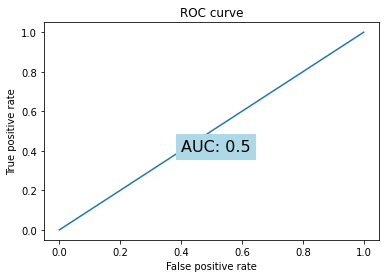

In [19]:
plot_roc(test_set.labels, pred)